In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


import sys
import os

sys.path.append(os.path.abspath(".."))

from src.modeling_utils import * 


In [2]:
data = pd.read_csv('../data/BankChurners.csv')
data.columns = [x.lower() for x in data.columns]

In [3]:
data['gender'] = data['gender'].map({"M":1, "F": 0})
data['attrition_flag'] = data['attrition_flag'].map({"Attrited Customer" : 1, "Existing Customer": 0})
data.rename(columns={"attrition_flag" : "churn_flag"}, inplace=True)

# Split Train and Test Data

In [4]:
X = data.drop(columns=['churn_flag'])
y = data['churn_flag']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

On this dataset we have no missing value and the outlier does not represent incosistent information thus data cleaning does not necessary

# Feature Engineering

To extract maximum information from the available features, we will create the following features
- Ratio Feature
    - products_per_dependent (total_relationship_count/dependent_count)
    - trans_amt_per_dependent (total_trans_amt/dependent_count) 
    - trans_ct_per_dependent (total_trans_ct/dependent_count)
    - trans_amt_per_products (total_trans_amt/total_relationship_count)
    - trans_ct_per_products (total_trans_ct/total_relationship_count)
    - avg_trans_amt (total_trans_amt/total_trans_ct)
    - credit_util_rate (total_revolving_bal/credit_limit)
    - proportion_inactive_months (months_inactive_12_mon/months_on_book)
    - products_per_tenure (total_relationship_count/months_on_book)
    - products_per_contacts (total_relationship_count/contacts_count_12_mon)
    - dependents_per_contacts (dependent_count/contacts_count_12_mon)
    - trans_ct_per_contacts (total_trans_ct/contacts_count_12_mon)
    - products_per_inactivity (total_relationship_count/months_inactive_12_mon)
    - dependents_per_inactivity (dependent_count/months_inactive_12_mon)
    - trans_ct_per_inactivity (total_trans_ct/months_inactive_12_mon)
    - trans_amt_per_credit_limit (total_trans_amt/credit_limit)
    - age_per_tenure (customer_age/months_on_book)
    - trans_ct_per_tenure (total_trans_ct/months_on_book)
    - trans_amt_per_tenure (total_trans_amt/months_on_book)

- Sum Feature
    - total_spending (total_trans_amt + total_revolving_bal)
    - education_income_levels (education_level + income_category)
    - inactivity_contacts (contacts_count_12_mon + months_inactive_12_mon)


- We leave the 'unknown' category in income_category, marital_status and education_level as another category of these variables. This is because on eda  this category presents discrimination between churners and non-churners. Specifically, in marital_status, it presents the highest churn rate. For education_level and income_category, it presents the second highest churn rates. Thus, I will not do any imputation. Imputing would introduce bias and information loss.

- I will leave the card_category variable in the data because although it is highly imbalanced, it was observed that Gold and Silver category present some higher churn rates. Once I intend to build robust models such as LightGBM, focusing on predictive power, I will keep this variable and apply a feature selection method to remove it in case it is useless.

- I will drop avg_open_to_buy because I observed it is perfectly positively correlated with credit_limit, turning its information redundant.

- I will drop CLIENTNUM because it has a unique value for each record.



## preprocessor for linear model

In [5]:
# Construct the preprocessor for linear models.
one_hot_encoding_features = ['gender', 
                             'education_level', 
                             'marital_status', 
                             'income_category', 
                             'card_category']
std_scaling_features = ['customer_age', 
                        'dependent_count', 
                        'months_on_book', 
                        'total_relationship_count', 
                        'months_inactive_12_mon', 
                        'contacts_count_12_mon', 
                        'credit_limit', 
                        'total_revolving_bal', 
                        'avg_open_to_buy', 
                        'total_amt_chng_q4_q1', 
                        'total_trans_amt', 
                        'total_trans_ct', 
                        'total_ct_chng_q4_q1',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'trans_ct_per_dependent',
                        'trans_amt_per_products',
                        'trans_ct_per_products',
                        'avg_trans_amt',
                        'credit_util_rate',
                        'proportion_inactive_months',
                        'products_per_tenure',
                        'products_per_contacts',
                        'dependents_per_contacts',
                        'trans_ct_per_contacts',
                        'products_per_inactivity',
                        'dependents_per_inactivity',
                        'trans_ct_per_inactivity',
                        'trans_amt_per_credit_limit',
                        'age_per_tenure',
                        'trans_ct_per_tenure',
                        'trans_amt_per_tenure',
                        'total_spending',
                        'inactivity_contacts',
                        'education_income_levels']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
]

linear_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('std_scaler', StandardFeatureScaler(to_scale=std_scaling_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)


X_train_prepared_linear = linear_preprocessor.fit_transform(X_train)
X_train_prepared_linear.shape

(8101, 56)

In [6]:
X_train_prepared_linear.head()

,avg_utilization_ratio,gender_1,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,education_level_Unknown,marital_status_Married,marital_status_Single,...,products_per_inactivity,dependents_per_inactivity,trans_ct_per_inactivity,trans_amt_per_credit_limit,age_per_tenure,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels
0,0.868,0,0,0,0,0,0,1,1,0,...,-0.485952,-1.237821,-0.880000,-0.381331,0.816497,-0.178604,-0.494497,-0.442467,0.129437,-1.477093
1,0.000,1,0,0,1,0,0,0,0,1,...,0.365249,0.264667,-0.663276,-1.013049,-0.443162,-0.943028,-0.578903,-0.922191,0.129437,0.026353
2,0.078,1,0,0,1,0,0,0,1,0,...,0.000449,-0.570049,-0.200931,-0.718602,0.967656,1.160665,0.107518,-0.102463,-0.526738,0.527502
3,0.510,0,0,1,0,0,0,0,1,0,...,0.730050,0.765496,0.290311,-0.545573,0.816497,-0.224470,-0.531703,-0.650920,-0.526738,0.026353
4,0.034,1,0,1,0,0,0,0,0,1,...,0.000449,-0.736992,0.073587,-0.989645,-0.317196,-0.123566,-0.288816,-0.139928,0.129437,2.030949


## preprocessor for tree model

* For the tree model we will not apply feature scaling for the numerical feature since tree models are not distance based model
* Categorical Feature that has ordinal characteristic (education_level, income_category, card_category) will be feed into ordinal encoder to preserve its characteristic
* Marital Status will be applied target encoding since, one hot encoding can be harmful to tree based models
* One hot enoding will be applied only to gender because it will be converted into unique binary variable, and not increasing the dimensionality

In [7]:
one_hot_encoding_features = ['gender']

ordinal_encoding_orders = {
    'education_level': ['Uneducated',
                        'High School',
                        'College',
                        'Graduate',
                        'Post-Graduate',
                        'Doctorate',
                        'Unknown'],
    'income_category': ['Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +',
                        'Unknown'],
    'card_category': ['Blue',
                      'Silver',
                      'Gold',
                      'Platinum']
}


target_encoding_features = ['marital_status']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']




tree_preporcessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('ordinal_encoder', OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)),
        ('target_encoder', TargetFeatureEncoder(to_encode=target_encoding_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)


X_train_prepared_tree = tree_preporcessor.fit_transform(X_train, y_train)
X_train_prepared_tree.shape

(8101, 40)

In [8]:
X_train_prepared_tree.head()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,...,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels,gender_1,education_level,income_category,card_category,marital_status
0,36,0,24,4,3,2,2570.0,2230.0,0.686,1755.0,...,1.750000,73.125000,3985,5,0,0,6,0,0,0.153397
1,44,3,36,5,2,3,25276.0,0.0,0.849,2282.0,...,1.055556,63.388889,2282,5,3,1,1,2,1,0.168998
2,46,2,30,6,3,1,11670.0,915.0,0.892,4277.0,...,2.966667,142.566666,5192,4,4,1,1,3,0,0.153397
3,36,2,24,3,1,3,3124.0,1593.0,0.869,1652.0,...,1.708333,68.833336,3245,4,3,0,3,0,0,0.153397
4,50,1,40,4,2,3,34516.0,1185.0,0.725,3874.0,...,1.800000,96.849998,5059,5,7,1,3,4,0,0.168998


# Model Training, Comparison, Selection and Tuning

- On this step,  we will compare different models performances. In order to achieve this, we will use stratified k-fold cross validation to train each one of them and evaluate their ROC-AUC score. Accuracy is not a good metric because the target is imbalanced. Moreover, stratified k-fold cross validation will maintain the target proportion on each fold, dealing with the imbalanced target as well.

- K-fold cross-validation is a technique used in machine learning to assess the performance of a model. It involves dividing the dataset into K subsets, using K-1 for training and one for testing iteratively. This helps in estimating a model's generalization ability by reducing the risk of overfitting and providing more reliable performance metrics.


In [9]:
linear_models = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }

tree_models = {
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'LightGBM': LGBMClassifier()
              }

Logistic Regression results: 
--------------------------------------------------
Training score: 0.8155285215206267
Average validation score: 0.9428411098157039
Standard deviation: 0.005198697289769655
Training time: 0.10181 seconds

Linear SVC results: 
--------------------------------------------------
Training score: 0.813085540048471
Average validation score: 0.9423902411475543
Standard deviation: 0.005039331756390566
Training time: 0.07751 seconds

KNN results: 
--------------------------------------------------
Training score: 0.8689001996995583
Average validation score: 0.9289760138141601
Standard deviation: 0.012751969695901285
Training time: 0.00183 seconds



,model,avg_val_score,train_score
0,Logistic Regression,0.942841,0.815529
1,Linear SVC,0.942390,0.813086
2,KNN,0.928976,0.868900


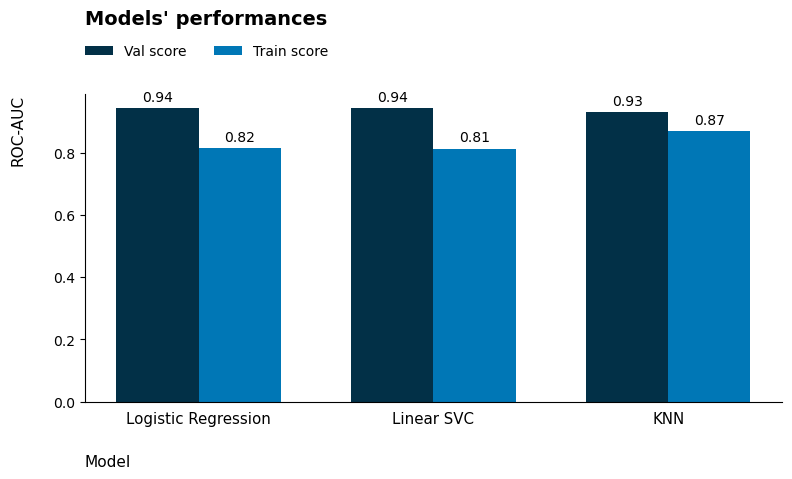

In [10]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_train_prepared_linear, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

Decision Tree results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.8739952975264387
Standard deviation: 0.006817962180055119
Training time: 0.15573 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.9882115602990906
Standard deviation: 0.002353027556875983
Training time: 1.49274 seconds

[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5536
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start training from score -1.652874
[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [In

,model,avg_val_score,train_score
0,LightGBM,0.992292,1.0
1,Random Forest,0.988212,1.0
2,Decision Tree,0.873995,1.0


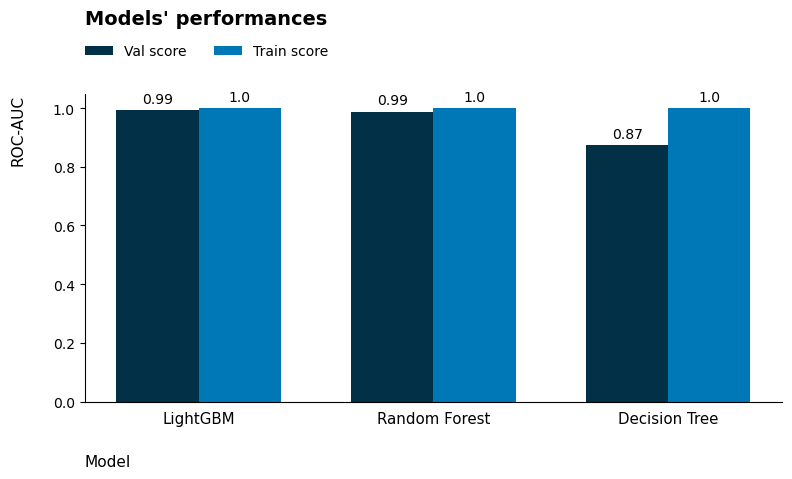

In [11]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train_prepared_tree, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

Although the model is overfitted, with a 1 ROC-AUC score on training data, its validation score is very close (0.99). This outstanding performance is not because data leakage, once all the features included are present at the moment of prediction and the split was made before everything. It is due to the quality of the data, the independent variables clearly separate churners and non-churners. Moreover, because of the result, hyperparameter tuning would not even add any performance. However, for demonstration purposes we will apply the hyperparameter tuning

# Feature Selection 

* feature selection is important in improving the model generalization ability and making it less complex, thus reducing computational cost
* Given that we have 40 features, simplifying the model without losing its performance is highly advantageous
* We will use Recursive Feature Elimination (RFE) for the feature selection
* Recursive Feature Elimination (RFE) is a feature selection method that systematically removes irrelevant or less important features from a predictive model. It works by recursively training the model on subsets of features, ranking them based on their importance, and eliminating the least important features until the desired number of features is reached
* An important hyperparameter of RFE is the final desired number of features. In order to automatically select this value, I will use sklearn's RFECV class. It will apply stratified k-fold cross validation to find the best value for this hyperparameter.

In [12]:
rfe = RecursiveFeatureEliminator(n_folds=5, 
                                 scoring='roc_auc',
                                 estimator=LGBMClassifier())
rfe.fit(X_train_prepared_tree, y_train)
X_train_selected = rfe.transform(X_train_prepared_tree)
X_train_selected.shape

[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160648 -> initscore=-1.653413
[LightGBM] [Info] Start training from score -1.653413
[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5524
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160648 -> initscore=-1.653413
[LightGBM] [Info] Start training from score -1.653413
[LightGBM] [Info] 

(8101, 25)

In [13]:
X_train_prepared_linear.shape

(8101, 56)

In [14]:
X_train_selected.columns

Index(['customer_age', 'contacts_count_12_mon', 'credit_limit',
       'total_revolving_bal', 'total_amt_chng_q4_q1', 'total_trans_amt',
       'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio',
       'trans_amt_per_dependent', 'trans_ct_per_dependent',
       'trans_amt_per_products', 'trans_ct_per_products', 'avg_trans_amt',
       'proportion_inactive_months', 'products_per_tenure',
       'trans_ct_per_contacts', 'products_per_inactivity',
       'trans_ct_per_inactivity', 'trans_amt_per_credit_limit',
       'age_per_tenure', 'trans_ct_per_tenure', 'trans_amt_per_tenure',
       'total_spending', 'education_income_levels'],
      dtype='object')

* As we can see, features that showed a clear discrimination between churners and non-churners were maintained, such as total_trans_ct and total_trans_amt. Moreover, a lot of features created from the feature engineering were also maintained, demonstrating the importance of this task for model's performance.
* As a result, we went from 50 features to 25 final most important features, significantly reducing the computational complexity.

## Hyperparameter Tuning

In [15]:
import optuna
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'objective': 'binary',
        'metric': 'roc_auc',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'class_weight': 'balanced', 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Train the LightGBM model with the sampled hyperparameters.
    model = LGBMClassifier(**params)
    
    # Obtain average stratified k-fold cross validation roc-auc score.
    stratified_kfold = StratifiedKFold(n_splits=5, 
                                       shuffle=True, 
                                       random_state=42)
    val_scores = cross_val_score(model, 
                                 X_train_selected, 
                                 y_train, 
                                 scoring='roc_auc', 
                                 cv=stratified_kfold)
    avg_roc_auc = val_scores.mean()
    
    return avg_roc_auc

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-12-24 13:21:31,866] A new study created in memory with name: no-name-7f73df05-7fb7-4da3-9836-30c3dda55b09
[I 2025-12-24 13:21:57,047] Trial 0 finished with value: 0.9862971377209654 and parameters: {'learning_rate': 0.002054655814694252, 'num_leaves': 116, 'subsample': 0.41122911762913467, 'colsample_bytree': 0.7081804512161484, 'min_data_in_leaf': 42}. Best is trial 0 with value: 0.9862971377209654.
[I 2025-12-24 13:22:11,870] Trial 1 finished with value: 0.9905991238728461 and parameters: {'learning_rate': 0.005450087410526477, 'num_leaves': 554, 'subsample': 0.39552676615829524, 'colsample_bytree': 0.7061823417795401, 'min_data_in_leaf': 81}. Best is trial 1 with value: 0.9905991238728461.
[I 2025-12-24 13:22:36,261] Trial 2 finished with value: 0.9923992793730569 and parameters: {'learning_rate': 0.0340362696259763, 'num_leaves': 1003, 'subsample': 0.5376306788984987, 'colsample_bytree': 0.4988213866928629, 'min_data_in_leaf': 68}. Best is trial 2 with value: 0.992399279373

Best Hyperparameters: {'learning_rate': 0.015313633643328951, 'num_leaves': 237, 'subsample': 0.76948859226788, 'colsample_bytree': 0.5584886057899195, 'min_data_in_leaf': 7}


In [16]:
best_params = {
    'objective': 'binary',
    'metric': 'roc_auc',
    'n_estimators': 1000,
    'verbosity': -1,
    'bagging_freq': 1,
    'class_weight': 'balanced', 
    'learning_rate': 0.017719279416687824, 
    'num_leaves': 15, 
    'subsample': 0.4081991970619253, 
    'colsample_bytree': 0.7018530538422882, 
    'min_data_in_leaf': 51}

lgb_clf = LGBMClassifier(**best_params)
lgb_clf.fit(X_train_selected, y_train)

,boosting_type,'gbdt'
,num_leaves,15
,max_depth,-1
,learning_rate,0.017719279416687824
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [17]:
X_test_prepared = tree_preporcessor.transform(X_test)
X_test_selected = rfe.transform(X_test_prepared)
X_test_selected.shape

(2026, 25)

In [18]:
y_pred = lgb_clf.predict(X_test_selected)

In [58]:
churn_probas = lgb_clf.predict_proba(X_test_prepared, predict_disable_shape_check=True)[:,1]

In [ ]:
np.where(churn_probas==churn_probas.max())

(array([1152]),)

In [56]:
churn_probas[1152] * 100

np.float64(99.99377193557356)

In [ ]:
round(churn_probas[1152])

np.float64(1.0)

In [48]:
X_test_prepared.iloc[1152]

customer_age                    45.000000
dependent_count                  2.000000
months_on_book                  33.000000
total_relationship_count         1.000000
months_inactive_12_mon           3.000000
contacts_count_12_mon            3.000000
credit_limit                  1833.000000
total_revolving_bal              0.000000
total_amt_chng_q4_q1             0.549000
total_trans_amt               2037.000000
total_trans_ct                  31.000000
total_ct_chng_q4_q1              0.292000
avg_utilization_ratio            0.000000
products_per_dependent           0.500000
trans_amt_per_dependent       1018.500000
trans_ct_per_dependent          15.500000
trans_amt_per_products        2037.000000
trans_ct_per_products           31.000000
avg_trans_amt                   65.709679
credit_util_rate                 0.000000
proportion_inactive_months       0.090909
products_per_tenure              0.030303
products_per_contacts            0.333333
dependents_per_contacts          0

In [37]:
print(round(churn_probas.max() * 100,2))

99.99


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.87      0.90      0.89       325

    accuracy                           0.96      2026
   macro avg       0.93      0.94      0.93      2026
weighted avg       0.96      0.96      0.96      2026

Brier Score: 0.03
Gini: 0.98
KS: 0.9


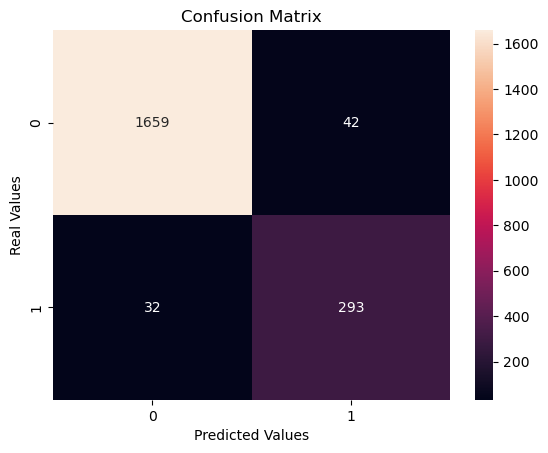

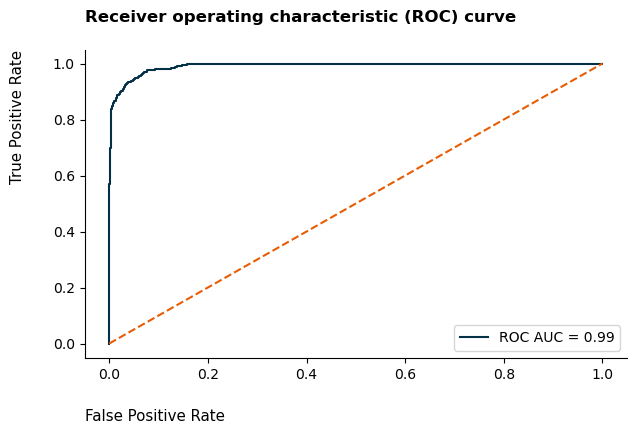

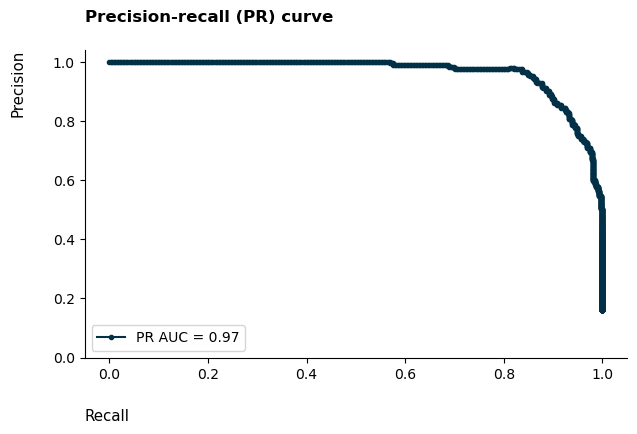

In [20]:
model_metrics = evaluate_classifier(y_test, y_pred, churn_probas)

In [21]:
model_metrics

,Metric,Value
0,Accuracy,0.963475
1,Precision,0.874627
2,Recall,0.901538
3,F1-Score,0.887879
4,ROC-AUC,0.991677
5,KS,0.899272
6,Gini,0.983355
7,PR-AUC,0.965489
8,Brier,0.026403


**Recall (0.90)** the model correctly identifies 90% of the churners. The model accurately predicted 293 out of 325 attrited customer

**Precision (0.87)** out of all customer that are predicted as churn, 90% of them are actually churners. Considering the confusion matrix, out of the 335 attrited customer 293 are predicted correctly

**ROC-AUC (0.99)** with an roc-auc of 0.99 the model demonstrate an outstanding ability to differentiate between attrited and existing customer.  if we randomly choose a customer that churned and a customer that dind't churn, in 99% of the time the model will estimate a higher probability of churn for that customer who actually attrited.

## Interpret the model with SHAP Values

to interpret the model result we will analyze the SHAP values


In [22]:
import shap

# intialize the shap values
explainer = shap.Explainer(lgb_clf)

# compute the shap values
shap_values = explainer(X_test_selected)


In [23]:
y_test.sample(10)

4620    0
1284    0
7900    1
8182    0
3571    0
6715    1
5150    0
3666    0
9270    0
3703    0
Name: churn_flag, dtype: int64

In [24]:
#Assess some true labels.
y_test.reset_index(drop=True).sample(10, random_state=42)

1284    0
982     0
1542    1
593     0
1292    1
781     0
1576    0
367     0
1782    0
1788    0
Name: churn_flag, dtype: int64

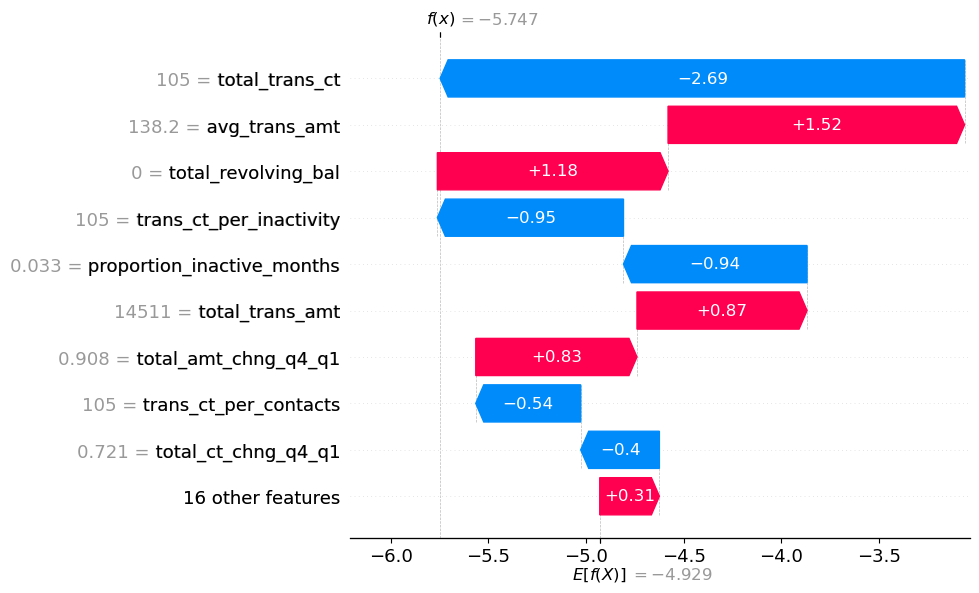

In [25]:
shap.plots.waterfall(shap_values[1])

# Save the Preprocessor, Model, RFE Feature Selector

In [62]:
from src.utils import save_object
save_object("../artifacts/preprocessor.pkl", tree_preporcessor)
save_object("../artifacts/model.pkl", lgb_clf)
save_object("../artifacts/feature_selector.pkl", rfe)